# **ПРОЕКТ: Маркетинг - Предсказание вероятности покупки**

**Описание проекта**  

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  

**Цель проекта:**  

Предсказать вероятность покупки в течение 90 дней.

**Главные задачи:**

- Загрузить и изучить данные  
- Провести предобработку и исследовательский анализ  
- Сконструировать новые признаки  
- Проверить на мультиколлинеарность  
- Создать и обучить модели для классификации пользователей   
- Улучшить модель и максимизировать метрику ROC-AUC
- Исследовать значимость признаков 

**Описание данных:**  

<u>Файл `apparel-purchases.csv`<u> 

История покупок

Содержит информацию о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

● `client_id` - идентификатор пользователя  
● `quantity` - количество товаров в заказе  
● `price` - цена товара  
● `category_ids` - вложенные категории, к которым отнсится товар  
● `date` - дата покупки  
● `message_id` - идентификатор сообщения из рассылки  

<u>Файл `apparel-messages.csv`<u>  

История рекламных рассылок  

Содержит рассылки, которые были отправлены клиентам из таблицы покупок.  

● `bulk_campaign_id` - идентификатор рассылки  
● `client_id` - идентификатор клиента  
● `message_id` - идентификатор сообщения  
● `event` - действие с сообщением (отправлено, открыто, покупка…)  
● `channel` - канал рассылки  
● `date` - дата действия  
● `created_at` - дата-время полностью  

<u>Файл `apparel-target_binary.csv`<u>  

Совершит ли клиент покупку в течение следующих 90 дней  

● `client_id` - идентификатор клиента  
● `target` - клиент совершил покупку в целевом периоде - целевой признак  

*Агрегированная по дням статистика по рассылкам:*  

<u>Файл `full_campaign_daily_event.csv`<u>  

Агрегация общей базы рассылок по дням и типам событий  

● `date` - дата  
● `bulk_campaign_id` - идентификатор рассылки  
● `count_event`* - общее количество каждого события `event`  
● `nunique_event`* = количество уникальных `client_id` в каждом событии  

   *в именах колонок есть все типы событий `event`  

<u>Файл `full_campaign_daily_event_channel.csv`<u>  

Агрегация по дням с учетом событий и каналов рассылки  

● `date` - дата  
● `bulk_campaign_id` - идентификатор рассылки  
● `count_event*_channel`* - общее количество каждого события по каналам  
● `nunique_event*_channel`* - количество уникальных `client_id` по событиям и каналам

  *в именах колонок есть все типы событий `event` и каналов рассылки `channel`  



## 1. Загрузка и изучение данных

**Импорт библиотек, определение настроек и констант**

In [1]:
!pip install category_encoders lightgbm -q
!pip install imbalanced-learn==0.14.0 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import catboost, phik, lightgbm
import warnings
import time
import os
import re

from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder,
    LabelEncoder, 
    OrdinalEncoder)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (roc_auc_score,
                             classification_report,
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import CatBoostEncoder
from sklearn.dummy import DummyClassifier

from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore")

In [3]:
import sklearn
import imblearn
print(f"scikit-learn version: {sklearn.__version__}")
print(f"imbalanced-learn version: {imblearn.__version__}")

scikit-learn version: 1.7.2
imbalanced-learn version: 0.14.0


**Загрузка данных из файлов**

In [4]:
folder_path = r'C:\Datasets'
file_names = ['apparel-purchases.csv', 'apparel-messages.csv', 'apparel-target_binary.csv', 'full_campaign_daily_event.csv', 'full_campaign_daily_event_channel.csv'  ]

dataframes = {}

for file in file_names:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        df_name = file.replace('.csv', '')  
        dataframes[df_name] = pd.read_csv(file_path)
        print(f"Файл {file} успешно загружен")
    else:
        print(f"Файл {file} не найден по пути: {file_path}")

Файл apparel-purchases.csv успешно загружен
Файл apparel-messages.csv успешно загружен
Файл apparel-target_binary.csv успешно загружен
Файл full_campaign_daily_event.csv успешно загружен
Файл full_campaign_daily_event_channel.csv успешно загружен


In [5]:
purchases = dataframes['apparel-purchases']
messages = dataframes['apparel-messages']
target = dataframes['apparel-target_binary']
event = dataframes['full_campaign_daily_event']
event_channel = dataframes['full_campaign_daily_event_channel']

In [6]:
def info (df):
    display(df.head(10))
    display(df.info()) 

<u>`purchases`<u> 

In [7]:
# Смотрим датафрейм `purchases` и общую информацию по нему
info(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

Датафрейм `purchases` состоит из 202208 строк и 6 столбцов, в которых находятся данные с типами object, int64 и float64.
Общее количество индексов в таблице составляет 202208, и такое же количество в каждом столбце, поэтому предположим, что столбцы не содержат пропусков.  
Названия стобцов имеют вид snake_case.

<u>`messages`<u> 

In [8]:
info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

Датафрейм `purchases` состоит из 12739798 строк и 7 столбцов, в которых находятся данные с типами object, int64.
Названия стобцов имеют вид snake_case.

<u>`target`<u> 

In [9]:
info(target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

Датафрейм `target` состоит из 49849 строк и 2 столбцов, в которых находятся данные с типом int64.
Общее количество индексов в таблице составляет 49849, и такое же количество в каждом столбце, поэтому предположим, что столбцы не содержат пропусков.  
Названия стобцов имеют вид snake_case.

<u>`event`<u>  

In [10]:
info(event)  

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

None

Датафрейм `event` состоит из 131072 строк и 24 столбцов, в которых находятся данные с типом int64 и object.
Общее количество индексов в таблице составляет 131072, и такое же количество в каждом столбце, поэтому предположим, что столбцы не содержат пропусков.  
Названия стобцов имеют вид snake_case.

<u>`event_channel`<u>

In [11]:
info(event_channel)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

None

Датафрейм `event_channel` состоит из 131072 строк и 36 столбцов, в которых находятся данные с типом int64 и object.
Общее количество индексов в таблице составляет 131072, и такое же количество в каждом столбце, поэтому предположим, что столбцы не содержат пропусков.  
Названия стобцов имеют вид snake_case.

**Выводы после первичного просмотра наборов данных:**

- Для работы были загружены пять таблиц.
- Названия стобцов во всех таблицах имеют вид snake_case.
- Предполагаем, что в таблицах нет пропусков. Подробнее изучим это в дальнейшем.
- Приведем столбцы с датой и временем к типу `datetime`.

## 2. Предобработка данных

### 2.1. Типы данных

Преобразуем тип данных в столбцах с датой и временем к типу `datetime`.

In [12]:
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')

In [13]:
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')

In [14]:
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [15]:
purchases['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 202208 entries, 0 to 202207
Series name: date
Non-Null Count   Dtype         
--------------   -----         
202208 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB


In [16]:
messages[['date', 'created_at']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 2 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   created_at  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 194.4 MB


### 2.2. Изучение и обработка пропущенных значений

In [17]:
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [18]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [19]:
target.isna().sum()

client_id    0
target       0
dtype: int64

In [20]:
event.isna().sum()[event.isna().sum()>0]

Series([], dtype: int64)

In [21]:
event_channel.isna().sum()[event_channel.isna().sum()>0]

Series([], dtype: int64)

Пропусков нет.

### 2.3. Изучение и обработка дубликатов

In [22]:
# Проверим наличие дубликатов в датафреймах
for i in [purchases, messages, target, event, event_channel]:
    #print(i.duplicated().sum()) 
    print(f'Явных дубликатов: {i.duplicated().sum()} ({i.duplicated().mean():.1%})')

Явных дубликатов: 73020 (36.1%)
Явных дубликатов: 48610 (0.4%)
Явных дубликатов: 0 (0.0%)
Явных дубликатов: 0 (0.0%)
Явных дубликатов: 0 (0.0%)


Посмотрим подобные строки

In [23]:
purchases[purchases.duplicated()].head()

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078


Для примера рассмотрим какой-нибудь один `client_id`

In [24]:
purchases.query('client_id==1515915625566606509')

,client_id,quantity,price,category_ids,date,message_id
20,1515915625566606509,1,349.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
23,1515915625566606509,1,999.0,"['5562', '5634', '5568', '957']",2022-05-16,1515915625566606509-4301-627b66245401d
24,1515915625566606509,1,399.0,"['5562', '5634', '5693', '636']",2022-05-16,1515915625566606509-4301-627b66245401d


Датасет `purchases` не содержит показателя, который был бы абсолютно уникален для каждого наблюдения, а дубликаты могут быть разными покупками (т.е., каждый дубликат - это второй (и последующий) товар в одном заказе), поэтому оставим их.  

In [25]:
messages[messages.duplicated()].head(13)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967567,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967904,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02
967938,5723,1515915625646938266,1515915625646938266-5723-62e2af09dde3e,click,mobile_push,2022-07-28,2022-07-28 16:18:23
967962,5723,1515915625591285393,1515915625591285393-5723-62e2af09ab0bb,click,mobile_push,2022-07-28,2022-07-28 16:20:36
968069,5723,1515915625471183369,1515915625471183369-5723-62e2af078221f,click,mobile_push,2022-07-28,2022-07-28 16:38:53
968076,5723,1515915625575043419,1515915625575043419-5723-62e2af09423a8,click,mobile_push,2022-07-28,2022-07-28 16:39:48
968198,5723,1515915625489431148,1515915625489431148-5723-62e2af07e03a7,click,mobile_push,2022-07-28,2022-07-28 17:11:45


Посмотрим какой-нибудь один `bulk_campaign_id`	

In [26]:
messages.query('bulk_campaign_id==5723').head(7)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
958776,5723,1515915625468062659,1515915625468062659-5723-62e2af076df60,send,mobile_push,2022-07-28,2022-07-28 15:45:11
958777,5723,1515915625468063399,1515915625468063399-5723-62e2af076dfa1,send,mobile_push,2022-07-28,2022-07-28 15:45:11
958778,5723,1515915625468064943,1515915625468064943-5723-62e2af076e136,send,mobile_push,2022-07-28,2022-07-28 15:45:11
958779,5723,1515915625468066562,1515915625468066562-5723-62e2af076e324,send,mobile_push,2022-07-28,2022-07-28 15:45:11
958780,5723,1515915625468061099,1515915625468061099-5723-62e2af076deaf,send,mobile_push,2022-07-28,2022-07-28 15:45:12
958781,5723,1515915625468061100,1515915625468061100-5723-62e2af076deb8,send,mobile_push,2022-07-28,2022-07-28 15:45:12
958782,5723,1515915625468063381,1515915625468063381-5723-62e2af076df99,send,mobile_push,2022-07-28,2022-07-28 15:45:12


Набор данных `messages` содержит колонку `created_at`, в которой указано время с точностью до секунд. Такие дубликаты необходимо удалить.

In [27]:
messages = messages.drop_duplicates().reset_index(drop=True)

In [28]:
# Проверим
messages.duplicated().sum()

0

В датасете `messages` у нас получается два столбца с датой. Сравним их.

In [29]:
# посмотрим строки, где разность между date и created_at больше суток
messages.query('abs((date - created_at).dt.days) > 1')['created_at'].count()

0

Таких строк нет, значит, один из столбцов можно рассматривать как избыточный, и теперь его можно удалить.

In [30]:
messages = messages.drop(columns=["created_at"])

In [31]:
messages.head(7)

,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19


### 2.4. Работа с признаками

**Обработка категорий товаров**

In [32]:
# Сделаем функцию для обработки вложенных категорий
def process_category_ids(category_series):
    
    # Тут разобьем строки категорий на списки
    categories = category_series.str.strip("[]").str.replace("'", "").str.split(", ")
        
    category_features = pd.DataFrame({
        #'category_depth': categories.apply(len),  # Сколько вложено
        'main_category': categories.apply(lambda x: x[0] if len(x) > 0 else None)
        #'sub_category': categories.apply(lambda x: x[1] if len(x) > 1 else None),
        #'all_categories': categories.apply(lambda x: '|'.join(x))  
    })
    
    return category_features


In [33]:
category_features = process_category_ids(purchases['category_ids'])
purchases = pd.concat([purchases, category_features], axis=1)
purchases.head(7)

,client_id,quantity,price,category_ids,date,message_id,main_category
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,2
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,2


In [34]:
purchases['main_category'].unique()

array(['4', '2', '5562', '1', 'None', '', '5963', '3', '6060', '5'],
      dtype=object)

In [35]:
# заменяем значения None и пропуски
purchases.loc[purchases['main_category'] == 'None', 'main_category'] = '77'
purchases.loc[purchases['main_category'] == '', 'main_category'] = '88'

In [36]:
purchases['main_category'].value_counts()

main_category
4       112578
5562     46511
2        27429
6060      7559
88        5579
5963      1272
77        1264
3           11
1            3
5            2
Name: count, dtype: int64

In [37]:
# удалим столбец category_ids
purchases = purchases.drop(columns=['category_ids'])

In [38]:
purchases.head(7)

,client_id,quantity,price,date,message_id,main_category
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4
5,1515915625471640575,1,3499.0,2022-05-16,1515915625471640575-4301-627b661b67ac3,2
6,1515915625490211585,1,1699.0,2022-05-16,1515915625490211585-4301-627b661843283,2


**Общая стоимость покупки**

In [39]:
# создаем столбец с общей стоимостью покупки 
purchases['total_purchase_value'] = purchases['price'] * purchases['quantity']

In [40]:
purchases.head()

,client_id,quantity,price,date,message_id,main_category,total_purchase_value
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,1999.0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,2499.0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,6499.0
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0


**Создание общего датафрейма**

In [41]:
# создаем датафрейм, сгруппированный по клиентам
purchases_by_client_id = purchases.drop(columns=['price', 'quantity', 'main_category', 'date', 'message_id']).groupby(by='client_id').sum()

In [42]:
# посмотрим на этот датафрейм
purchases_by_client_id.info()
purchases_by_client_id.head()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_purchase_value  49849 non-null  float64
dtypes: float64(1)
memory usage: 778.9 KB


,total_purchase_value
client_id,
1515915625468060902,6993.0
1515915625468061003,16235.0
1515915625468061099,299.0
1515915625468061100,2098.0
1515915625468061170,33601.0


Далее будем создавать новые столбцы

In [43]:
# столбец с последней датой покупки
purchases_by_client_id['last_date'] = purchases.drop(columns=['price', 'quantity', 'main_category', 'total_purchase_value', 'message_id']) \
                                                 .groupby(by='client_id').max()['date']
# столбец с первой датой покупки
purchases_by_client_id['first_date'] = purchases.drop(columns=["price", "quantity",'main_category', 'total_purchase_value', 'message_id']) \
                                                 .groupby(by='client_id').min()['date']
# столбец сколько дней назад была сделана последняя покупка 
purchases_by_client_id['days_since_last_purch'] = (purchases_by_client_id['last_date'].max() - purchases_by_client_id['last_date']).dt.days + 1

# столбец с периодом, в течение которого покупатель совершал покупки
purchases_by_client_id['purchase_period'] = (purchases_by_client_id['last_date'] - purchases_by_client_id['first_date']).dt.days + 1

# столбец с количеством единиц купленного товара для каждого клиента
purchases_by_client_id['quantity'] = purchases.drop(columns=['price', 'date','main_category', 'total_purchase_value', 'message_id']) \
                                                 .groupby(by='client_id').sum()['quantity']

# столбец с количеством уникальных категорий купленных товаров 
purchases_by_client_id['cat_count'] = purchases.drop(columns=["price", "quantity",'date', 'total_purchase_value', 'message_id']) \
                                                 .groupby(by='client_id').nunique()['main_category']
# столбец с доминирующей категорией купленных товаров 
purchases_by_client_id['main_category'] = pd.pivot_table(purchases, values='main_category', index=['client_id'], aggfunc='max')['main_category']
purchases_by_client_id['main_category'] = purchases_by_client_id['main_category'].replace(np.nan, '88')
# удаляем лишние столбцы
purchases_by_client_id = purchases_by_client_id.drop(columns=['last_date', 'first_date'])

In [44]:
purchases_by_client_id.head(10)

,total_purchase_value,days_since_last_purch,purchase_period,quantity,cat_count,main_category
client_id,,,,,,
1515915625468060902,6993.0,631,1,7,1,4
1515915625468061003,16235.0,409,1,7,1,4
1515915625468061099,299.0,641,1,1,1,4
1515915625468061100,2098.0,7,1,2,1,4
1515915625468061170,33601.0,245,84,19,3,88
1515915625468061514,999.0,567,1,1,1,4
1515915625468061877,1499.0,547,1,1,1,5562
1515915625468061975,299.0,570,1,1,1,4
1515915625468061994,1012.0,430,30,8,2,6060


In [45]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19


In [46]:
# создадим новые столбцы с положительными событиями
messages.loc[messages['channel'] == 'email', 'email'] = 1 
messages.loc[messages['channel'] == 'mobile_push', 'mobile_push'] = 1 
messages['email'].astype('bool')
messages['mobile_push'].astype('bool')
for _ in ['open','click','purchase','subscribe']:
    messages.loc[messages['event'] == _, _] = 1
    messages[_].astype('bool')      

Ссоздадим теперь датафрейм, сгруппированный по клиентам

In [47]:
messages_by_client_id = messages.drop(columns=['bulk_campaign_id', 'message_id', 'event', 'date', 'channel']).groupby(by='client_id').sum()

Посмотрим на датафрейм

In [48]:
messages_by_client_id.info()
messages_by_client_id.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   email        53329 non-null  float64
 1   mobile_push  53329 non-null  float64
 2   open         53329 non-null  float64
 3   click        53329 non-null  float64
 4   purchase     53329 non-null  float64
 5   subscribe    53329 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


,email,mobile_push,open,click,purchase,subscribe
client_id,,,,,,
1515915625468060902,177.0,0.0,35.0,10.0,5.0,0.0
1515915625468061003,165.0,0.0,5.0,5.0,1.0,0.0
1515915625468061099,182.0,94.0,51.0,8.0,0.0,0.0
1515915625468061100,0.0,428.0,157.0,1.0,1.0,0.0
1515915625468061170,202.0,91.0,31.0,16.0,3.0,0.0


Создадим теперь итоговый датафрейм

In [49]:
df = target.merge(purchases_by_client_id, on='client_id').merge(messages_by_client_id, on='client_id')

In [50]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              41982 non-null  int64  
 1   target                 41982 non-null  int64  
 2   total_purchase_value   41982 non-null  float64
 3   days_since_last_purch  41982 non-null  int64  
 4   purchase_period        41982 non-null  int64  
 5   quantity               41982 non-null  int64  
 6   cat_count              41982 non-null  int64  
 7   main_category          41982 non-null  object 
 8   email                  41982 non-null  float64
 9   mobile_push            41982 non-null  float64
 10  open                   41982 non-null  float64
 11  click                  41982 non-null  float64
 12  purchase               41982 non-null  float64
 13  subscribe              41982 non-null  float64
dtypes: float64(7), int64(6), object(1)
memory usage: 4.5+ 

,client_id,target,total_purchase_value,days_since_last_purch,purchase_period,quantity,cat_count,main_category,email,mobile_push,open,click,purchase,subscribe
0,1515915625468060902,0,6993.0,631,1,7,1,4,177.0,0.0,35.0,10.0,5.0,0.0
1,1515915625468061003,1,16235.0,409,1,7,1,4,165.0,0.0,5.0,5.0,1.0,0.0
2,1515915625468061099,0,299.0,641,1,1,1,4,182.0,94.0,51.0,8.0,0.0,0.0
3,1515915625468061100,0,2098.0,7,1,2,1,4,0.0,428.0,157.0,1.0,1.0,0.0
4,1515915625468061170,0,33601.0,245,84,19,3,88,202.0,91.0,31.0,16.0,3.0,0.0


In [51]:
# Проверим наличие пропусков в df
df.isna().sum()

client_id                0
target                   0
total_purchase_value     0
days_since_last_purch    0
purchase_period          0
quantity                 0
cat_count                0
main_category            0
email                    0
mobile_push              0
open                     0
click                    0
purchase                 0
subscribe                0
dtype: int64

In [52]:
# Проверим наличие дубликатов в df
df.duplicated().sum()

0

**Выводы:**

Проведена предобработка данных:

- столбцы с датой и временем были приведены к типу datetime;
- пропущенных значений обнаружено не было;
- были изучены и обработаны дубликаты;
- были удалены неинформативные признаки и созданы новые признаки;
- было произведено объединение датафреймов по ID клиентов.

## 3. Исследовательский анализ данных

Создадим функции для построения графиков:

In [53]:
# Функция для построения гистограммы для непрерывных признаков (var=1) или столбчатой диаграммы для дискретных признаков (var=2) 
    # и диаграммы размаха 
def num_plot(data, feature, title_1, xlabel, title_2, hue=None, var=1):
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    
    if var == 1:
        sns.histplot(data=data, x=feature, hue=hue, bins=50, ax=ax[0], kde=True)
        #ax[0].vlines(x=data[feature].median(), colors='red', ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), 
                     #lw=3, alpha=0.6, label='Медиана')
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].set_ylabel('Количество')
        ax[0].legend()
        ax[0].grid(True)
       
        if hue is not None:
            ax[0].legend(title=hue, labels=['0', '1'])
        
    if var == 2:
        sns.countplot(data, x=feature, hue=hue, ax=ax[0], color='#1f77b4', alpha=0.7)
        ax[0].set_title(title_1)
        ax[0].set_xlabel(xlabel)
        ax[0].tick_params(axis='x', labelrotation=30)
        ax[0].set_ylabel('Количество') 
        ax[0].grid(True)
        
        for p in ax[0].patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax[0].text(x+width/2, 
                       y+height*1.02, 
                       int(height), 
                       horizontalalignment='center', 
                       verticalalignment='center',
                       fontsize=12)  
    
    if hue is not None:
        # Boxplot с группировкой по hue
        sns.boxplot(data=data, y=feature, x=hue, ax=ax[1])
        ax[1].set_title(f'{title_2} по {hue}')
        ax[1].set_ylabel(xlabel)
        ax[1].set_xlabel(hue)
    else:
        # Обычный boxplot
        sns.boxplot(data=data, y=feature, ax=ax[1])
        ax[1].set_title(title_2)
        ax[1].set_ylabel(xlabel)
    
    ax[1].grid(True, alpha=0.3)
    
    #ax[1].boxplot(data[feature], vert=False)
   # ax[1].set_title(title_2)
    #ax[1].set_xlabel(xlabel)
    
    plt.grid(True)
    plt.show()

In [54]:
# Функция построения столбчатых и круговых диаграмм

def count_pie_plot(data, x, title, xlabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(
        data=data,
        x=x,
        hue=hue,
        order=data[x].value_counts().index,
        ax=axes[0]
    )
    axes[0].set_title(title)
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    for container in axes[0].containers:
        for bar in container:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{height}',
                        ha='center', va='center', 
                        fontsize=13, fontweight='bold', color='black')
                
    data[x].value_counts().plot(
        kind='pie',
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1]
    )
    axes[1].set_title(title)
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

<u>**Анализ количественных признаков**</u>

In [55]:
num_col_names = ['total_purchase_value', 'days_since_last_purch', 'purchase_period', 'quantity', \
'cat_count', 'email', 'mobile_push', 'open', 'click', 'purchase', 'subscribe']
print('Статистические характеристики данных')
df.drop(columns=['client_id', 'target']).describe().round(2).T
#display(df[num_col_names].describe().T)

Статистические характеристики данных


,count,mean,std,min,25%,50%,75%,max
total_purchase_value,41982.0,4794.76,7335.09,1.0,1499.0,2866.0,5598.0,540408.0
days_since_last_purch,41982.0,373.30,190.36,1.0,237.0,389.0,559.0,642.0
purchase_period,41982.0,23.77,80.38,1.0,1.0,1.0,1.0,637.0
quantity,41982.0,3.99,5.34,1.0,1.0,2.0,4.0,218.0
cat_count,41982.0,1.22,0.50,1.0,1.0,1.0,1.0,6.0
email,41982.0,114.93,92.60,0.0,12.0,122.0,184.0,870.0
mobile_push,41982.0,145.02,145.43,0.0,0.0,121.0,241.0,2294.0
open,41982.0,59.20,73.40,0.0,4.0,26.0,94.0,1268.0
click,41982.0,10.58,13.79,0.0,3.0,6.0,13.0,380.0
purchase,41982.0,1.33,1.31,0.0,1.0,1.0,1.0,81.0


Построим графики

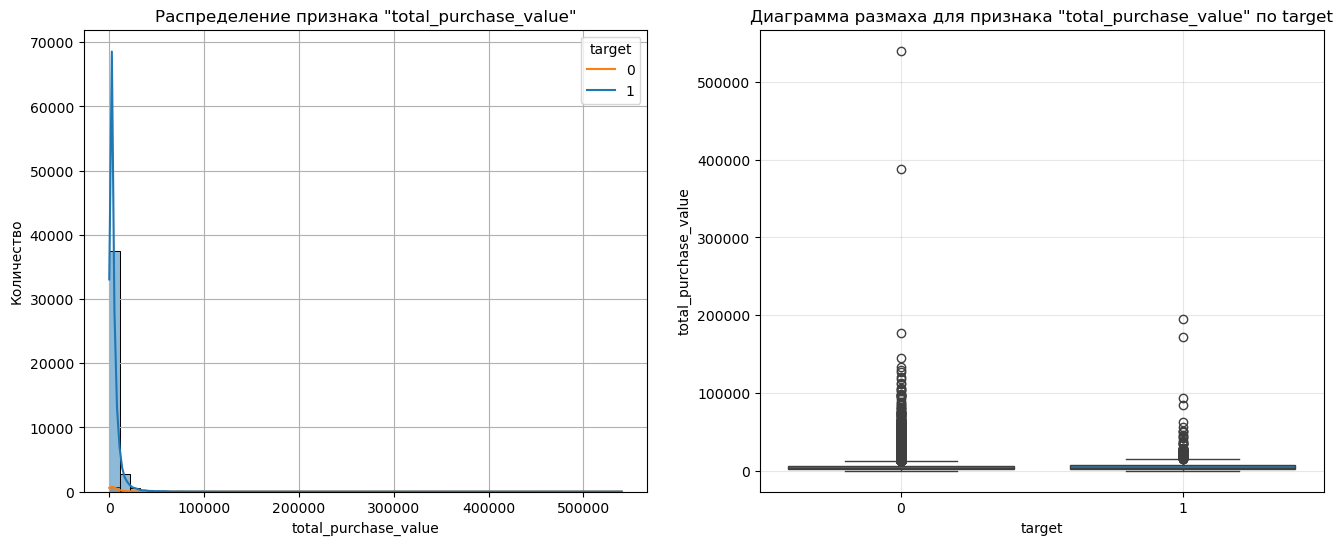

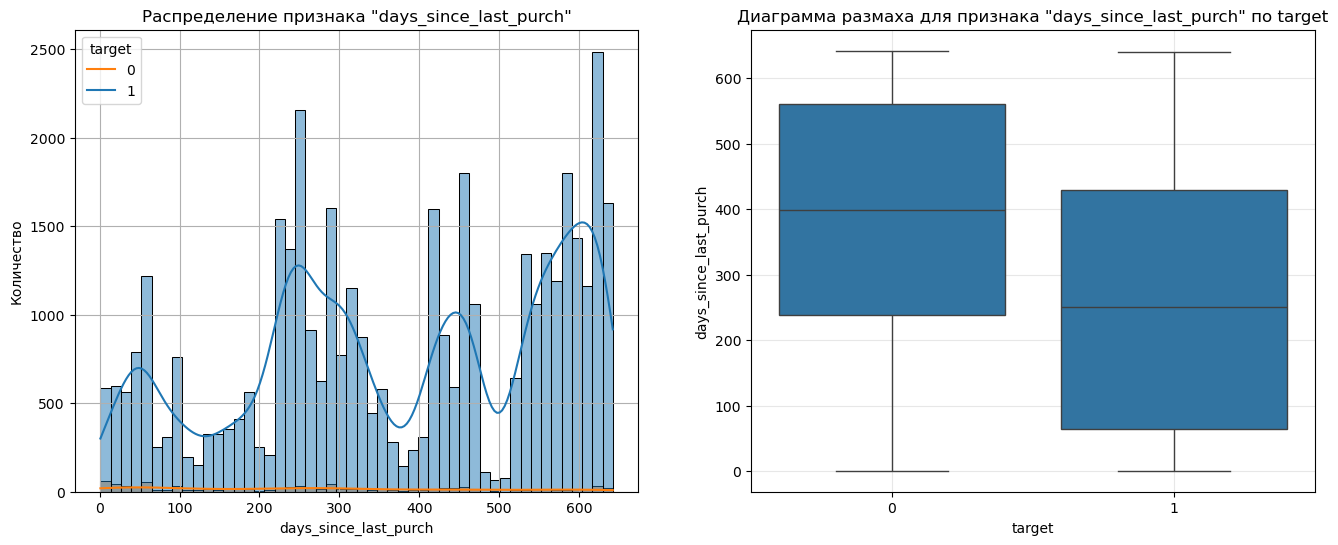

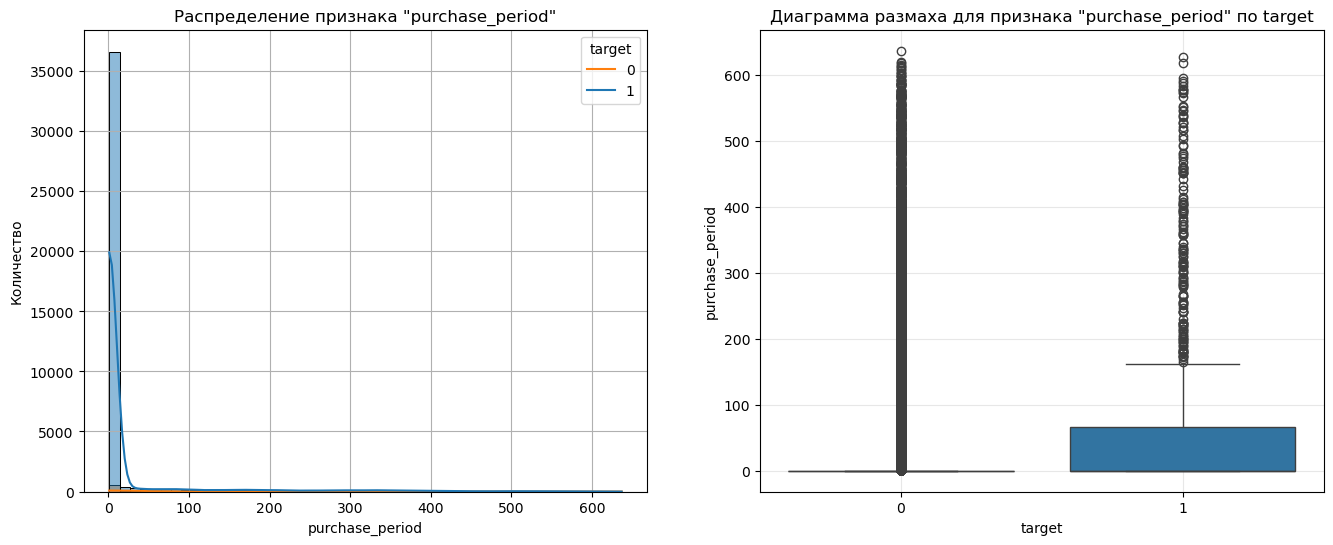

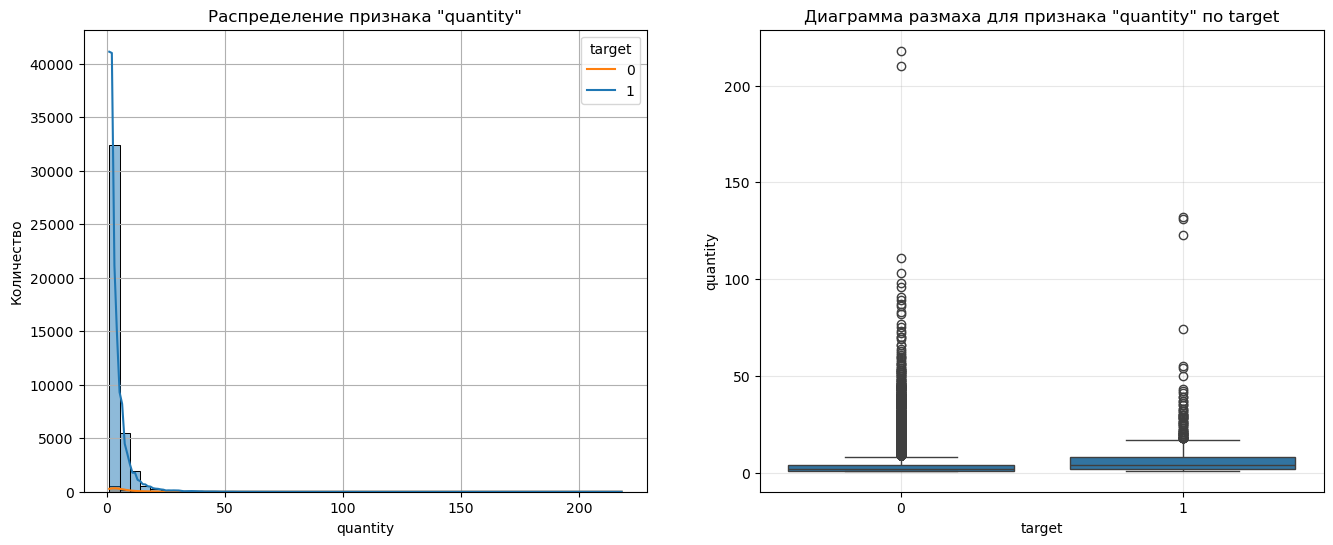

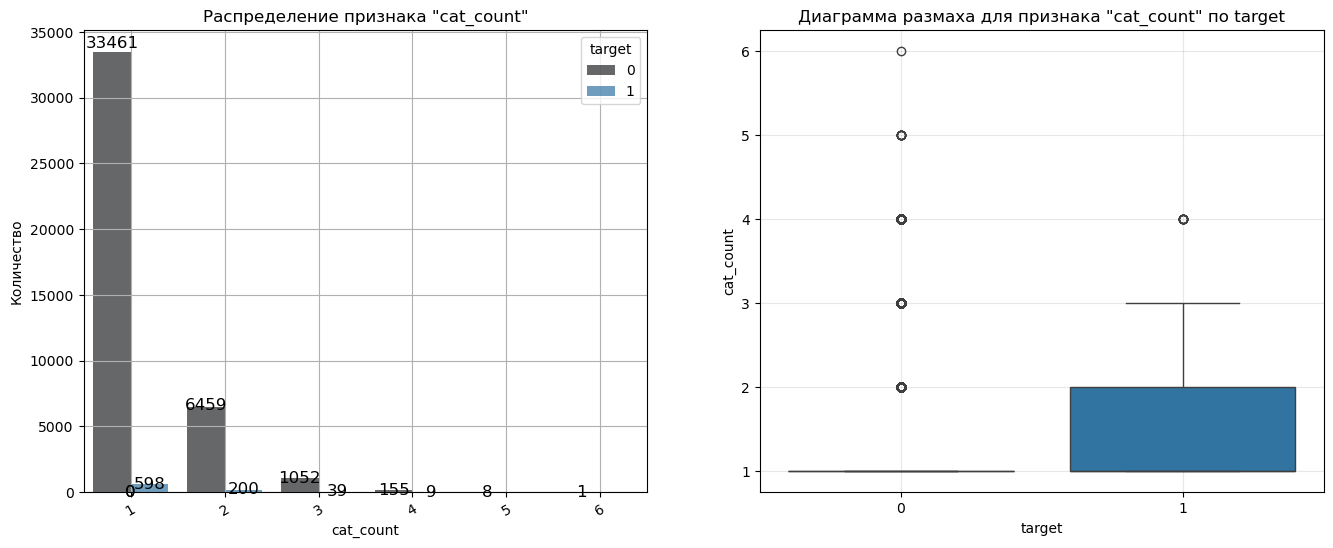

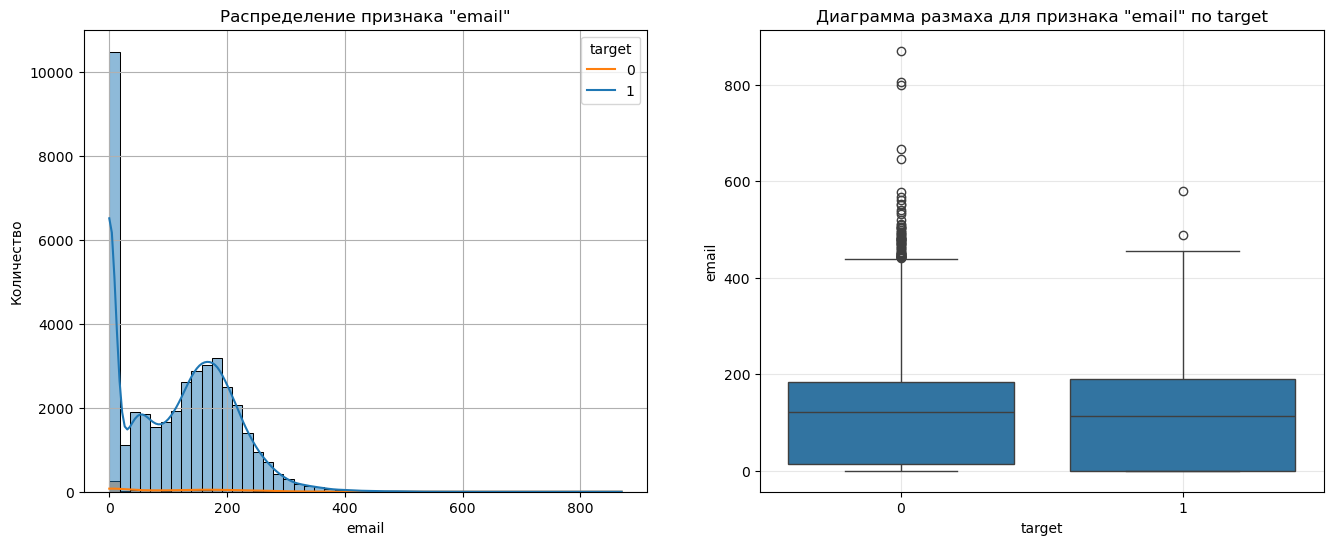

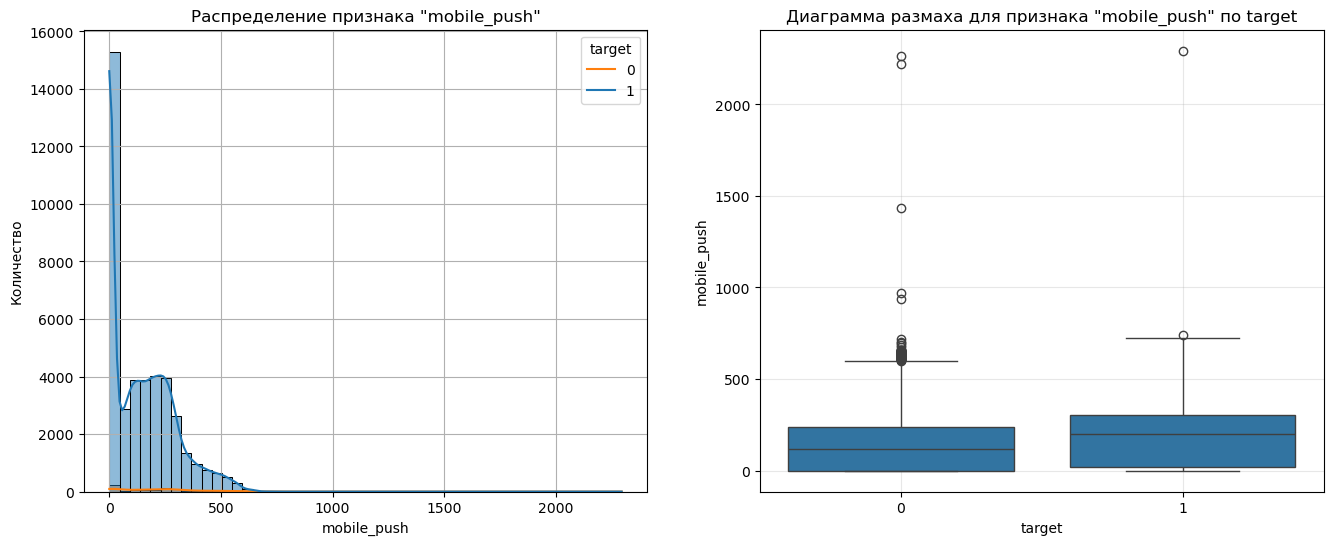

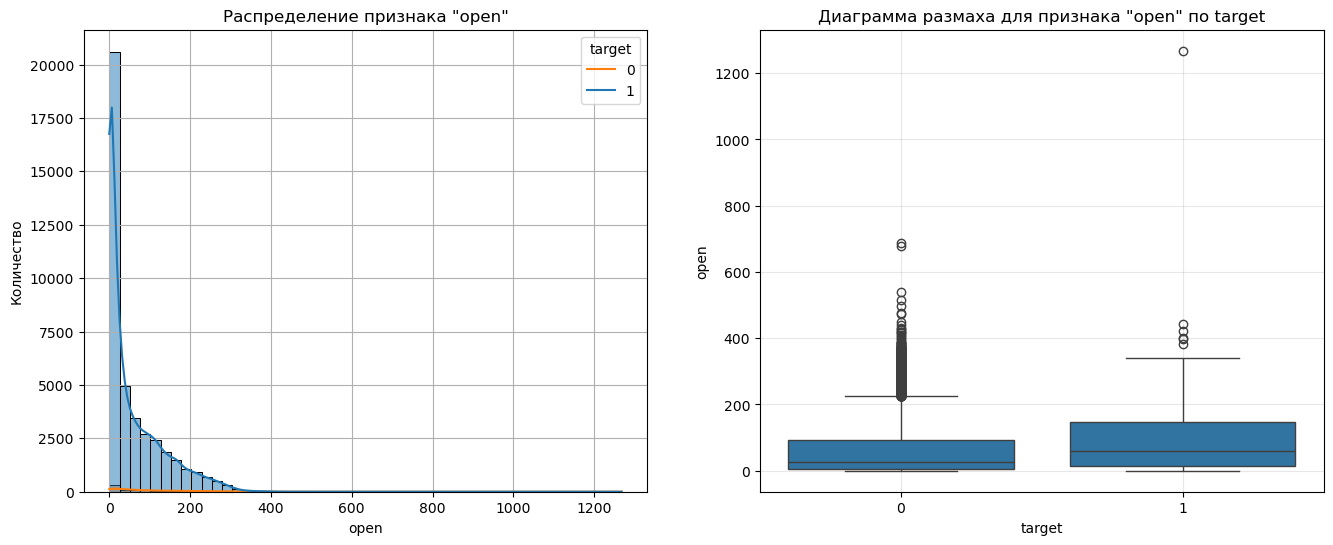

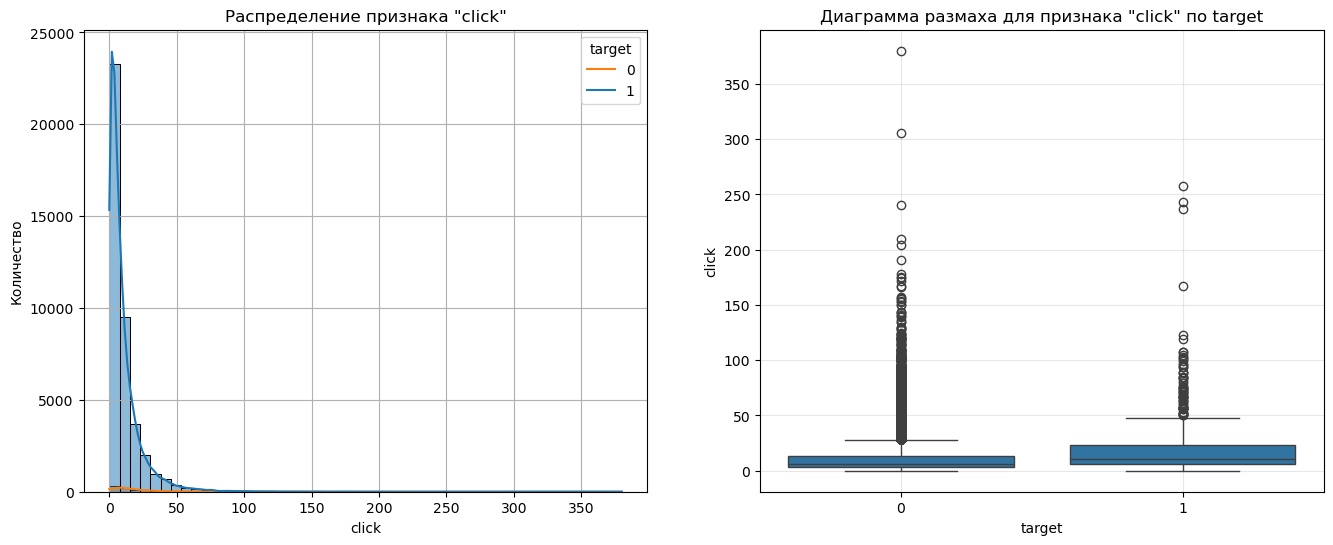

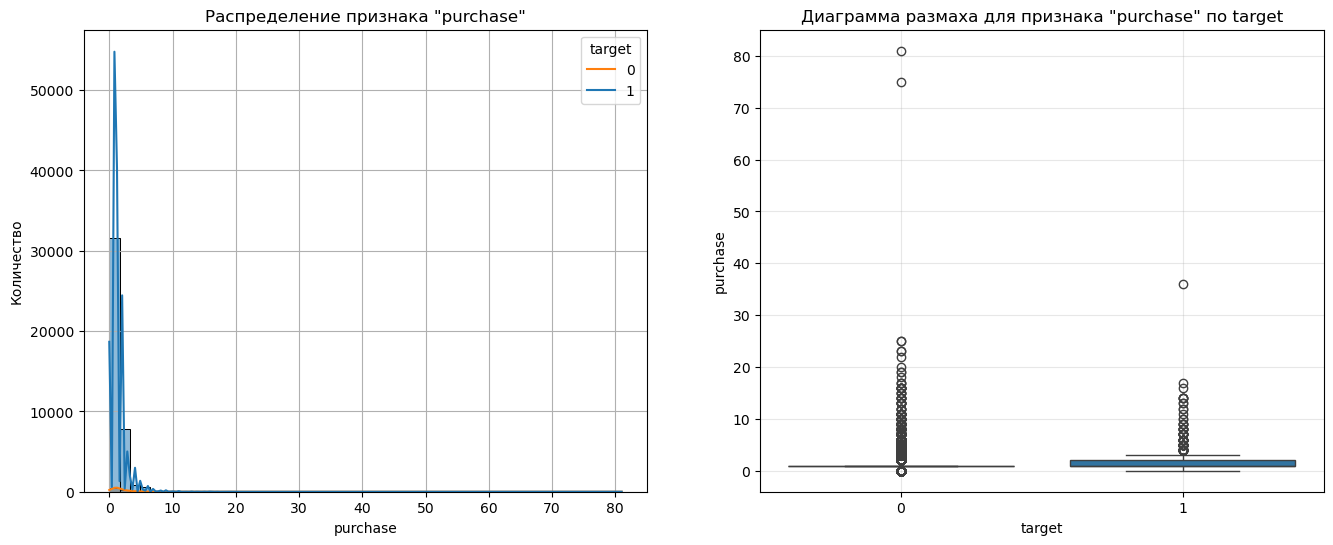

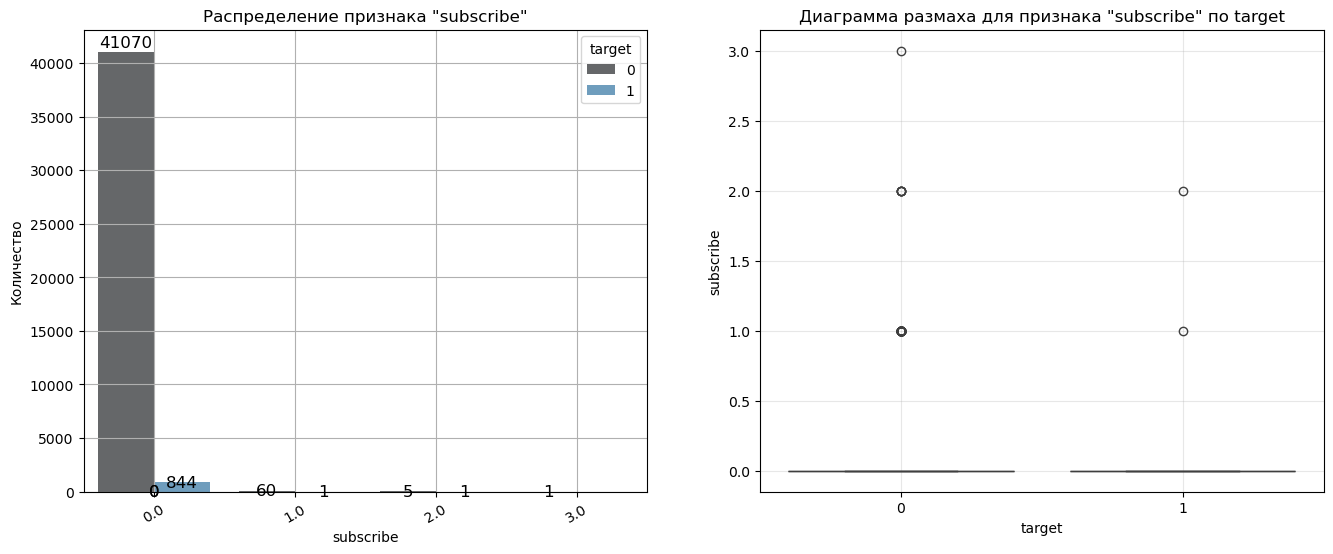

In [56]:

for i in num_col_names:
    if i not in ['cat_count', 'subscribe']:
        num_plot(
            data=df,
            feature=i, 
            title_1=f'Распределение признака "{i}"',
            xlabel=f'{i}',
            title_2=f'Диаграмма размаха для признака "{i}"',
            hue='target'
        )
    else:
        num_plot(
            data=df,
            feature=i,
            title_1=f'Распределение признака "{i}"', 
            xlabel=f'{i}',
            title_2=f'Диаграмма размаха для признака "{i}"',
            hue='target',
            var=2
        )

По признаку `total_purchase_value` (общая стоимость покупок) видны несколько аномальных значений, сильно выбивающихся из общего ряда. Посмотрим строки с общей стоимостью покупок более 180000 руб.

In [57]:
df.query('total_purchase_value > 200000')

,client_id,target,total_purchase_value,days_since_last_purch,purchase_period,quantity,cat_count,main_category,email,mobile_push,open,click,purchase,subscribe
22887,1515915625553309277,0,540408.0,53,3,20,1,4,0.0,223.0,39.0,2.0,3.0,0.0
40957,1515915625983356708,0,387583.0,31,1,37,2,88,0.0,143.0,54.0,2.0,1.0,0.0


Нашлось 2 таких строки. Эти значения очень сильно отличаются от большинства. Полагаю, их стоит удалить.

In [58]:
df = df.query('total_purchase_value <= 200000')

<u>**Анализ категориальных признаков**</u>

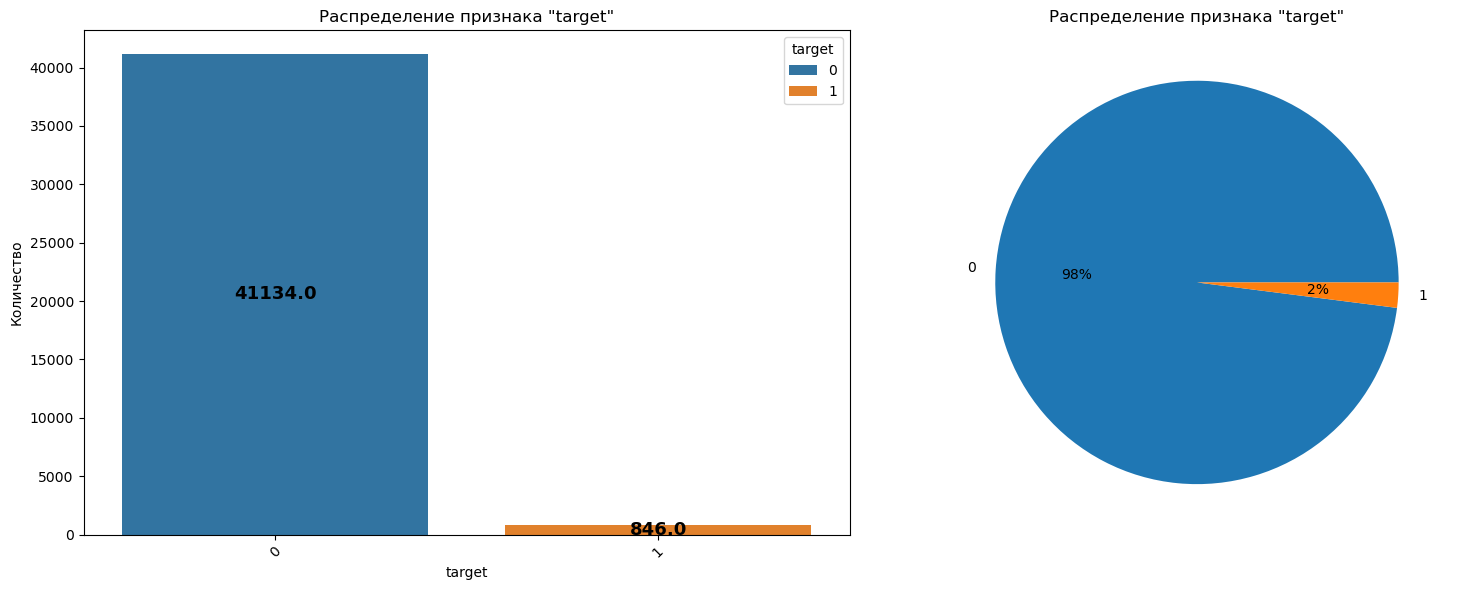

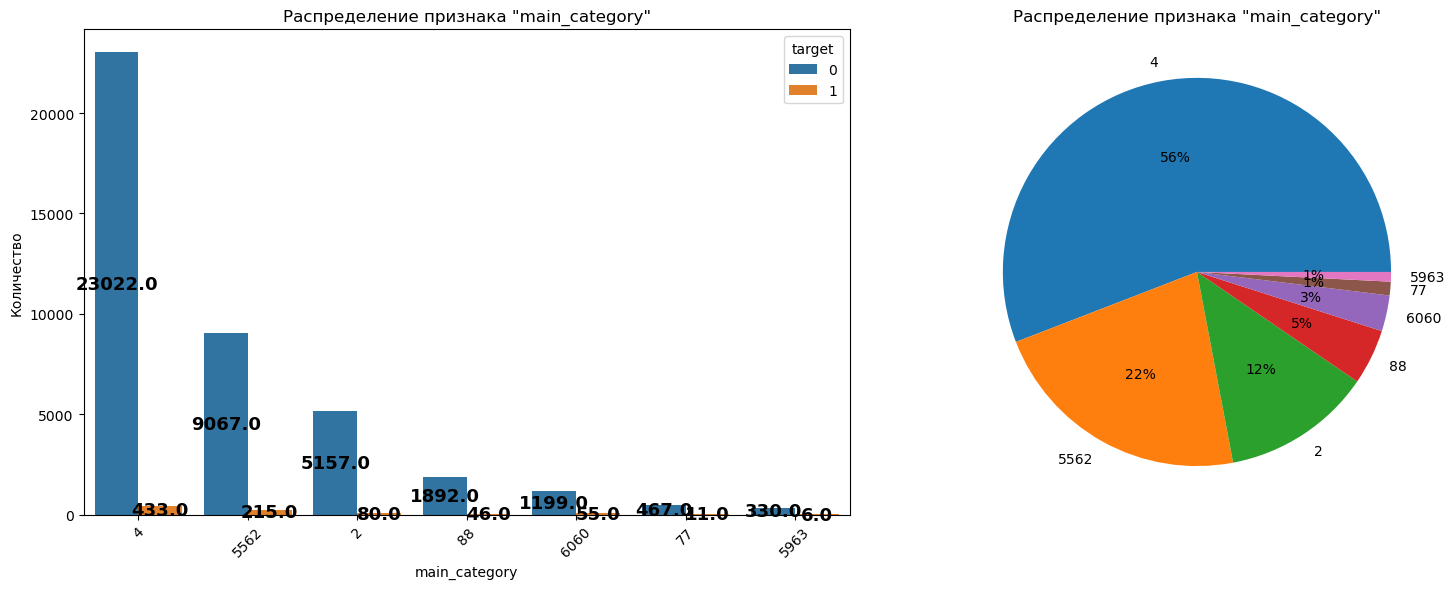

In [59]:
cat_col_names = ['target', 'main_category']
for i in cat_col_names:
    count_pie_plot(
        data=df,
        x=i,
        title=f'Распределение признака "{i}"', 
        xlabel=f'{i}',
        hue='target'
           )

По целевому признаку наблюдается значительный дисбаланс классов: доля значений 1 очень мала. Чтобы это учесть, можно будет воспользоваться сэмплированием или использовать class_weight. А для оценки качества модели будем использовать устойчивую к дисбалансу метрику ROC-AUC.  

Что касается основной категории товаров, то преобладает категория 4 - 56%.

## 4. Корреляционный анализ

Построим матрицу корреляции $\phi_K$ 

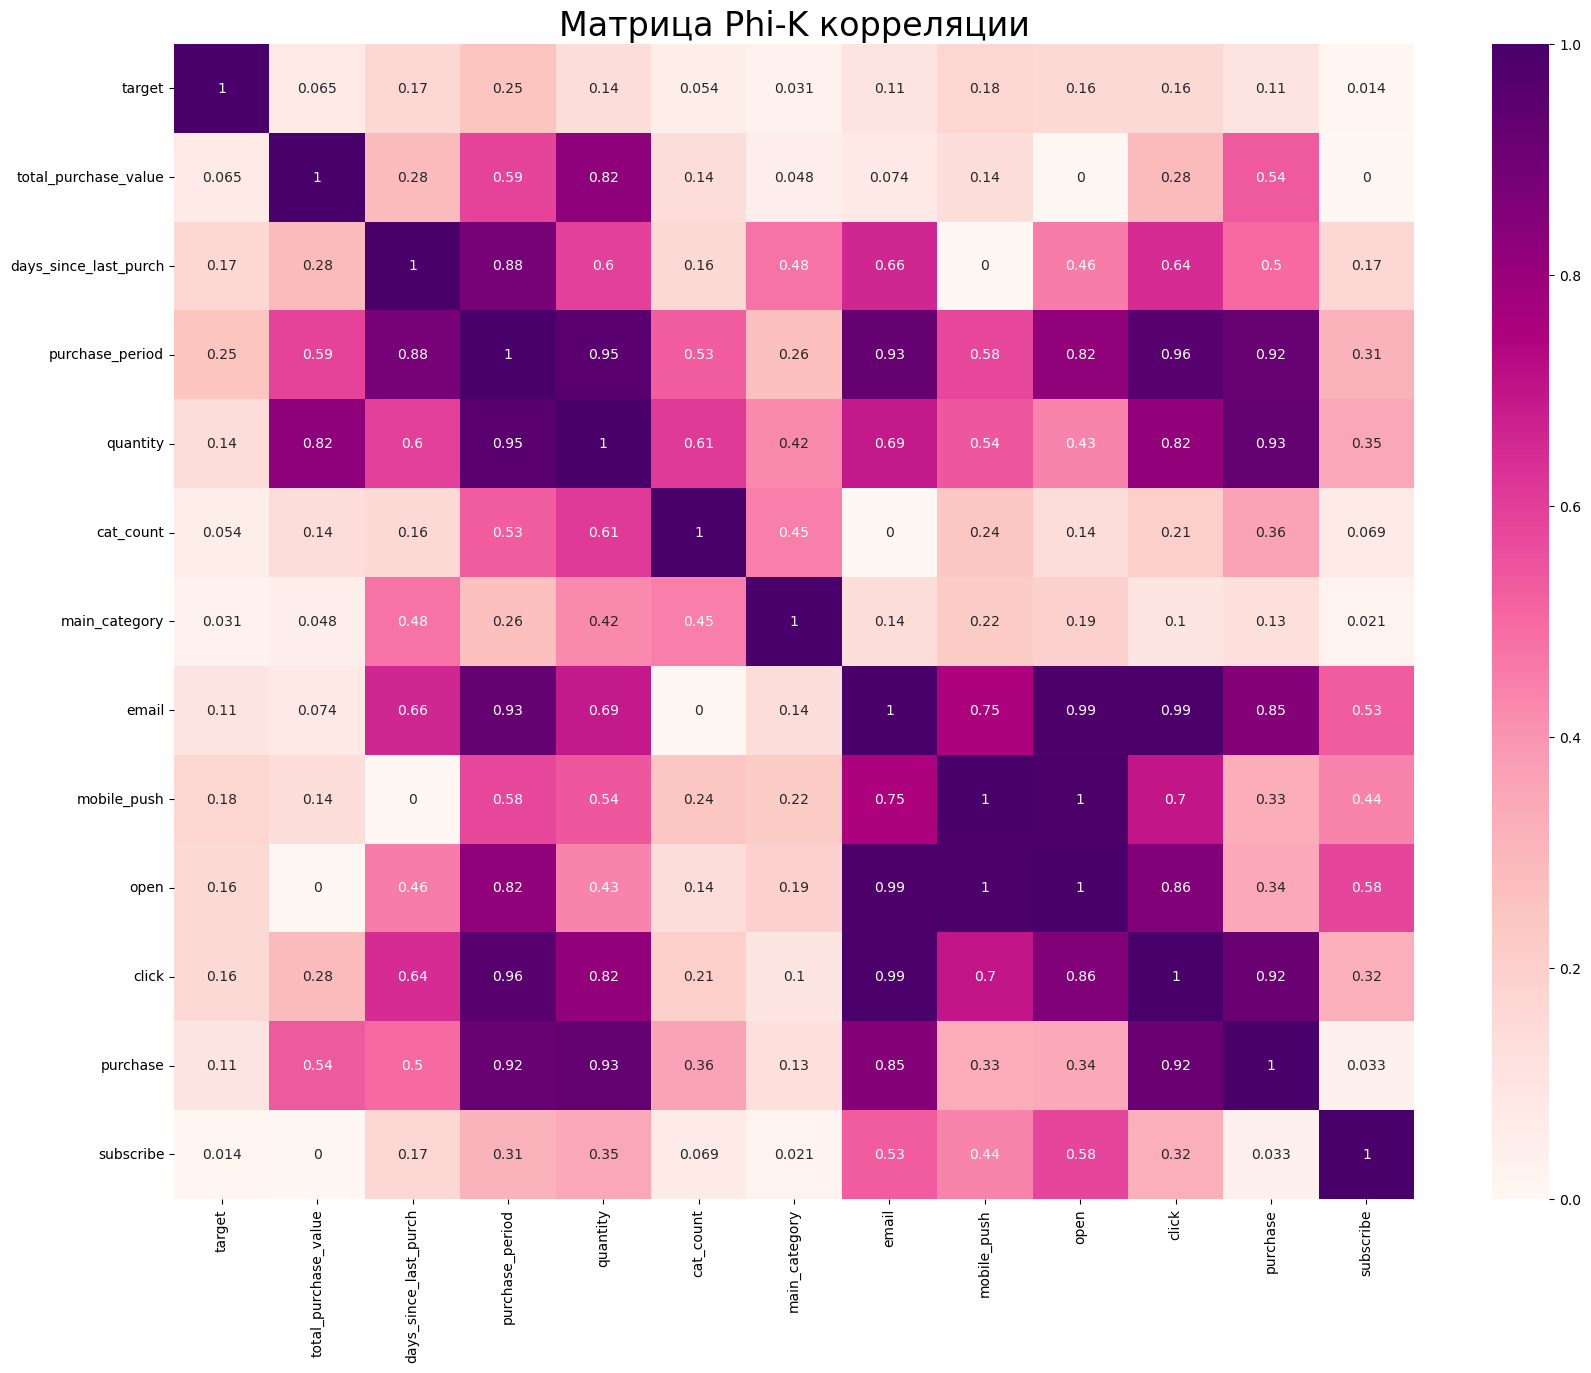

In [60]:
plt.figure(figsize=(20,15))
sns.heatmap(df.drop(columns=['client_id'], axis=1).phik_matrix(interval_cols=['total_purchase_value'])                     
                                         , annot=True, cmap='RdPu')
plt.title('Матрица Phi-K корреляции', fontsize=24)
plt.show()

Сильной корреляции у целевого признака с входными нет. Слабая корреляция у него с таким признаком как период, в течение которого совершались покупки, и совсем слабая с: день последней покупки, количество купленных товаров, каналы рассылки и действия с сообщением.

Выявлена высокая корреляция (0.82) между общей стоимостью покупок и количеством единиц товара. 

Высокая корреляция между каналом рассылки и действием с сообщением. Но эти признаки оставим.


**Проверка мультиколлинеарности и расчет VIF**

In [61]:
X = sm.add_constant(df[['total_purchase_value', 'days_since_last_purch', 'purchase_period', 'quantity', 'cat_count', 'email', 'mobile_push', 'open', 'click', 'purchase', 'subscribe']])

vif = pd.DataFrame()
vif['Переменная'] = X.columns
vif['Коэффициент VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif)

,Переменная,Коэффициент VIF
0,const,14.968167
1,total_purchase_value,1.483022
2,days_since_last_purch,1.141542
3,purchase_period,1.373309
4,quantity,1.974448
5,cat_count,1.305376
6,email,2.031700
7,mobile_push,2.795788
8,open,3.023711
9,click,1.414437


Ключевые пороги для VIF:

VIF < 5: Минимальная мультиколлинеарность, это нормально.  
5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.  
VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.  
Все признаки < 5 - мультиколлинеарности нет.

## 5. Обучение моделей и выбор лучшей модели и ее параметров

Еще раз посмотрим информацию по нашему датафрейму

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41980 entries, 0 to 41981
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              41980 non-null  int64  
 1   target                 41980 non-null  int64  
 2   total_purchase_value   41980 non-null  float64
 3   days_since_last_purch  41980 non-null  int64  
 4   purchase_period        41980 non-null  int64  
 5   quantity               41980 non-null  int64  
 6   cat_count              41980 non-null  int64  
 7   main_category          41980 non-null  object 
 8   email                  41980 non-null  float64
 9   mobile_push            41980 non-null  float64
 10  open                   41980 non-null  float64
 11  click                  41980 non-null  float64
 12  purchase               41980 non-null  float64
 13  subscribe              41980 non-null  float64
dtypes: float64(7), int64(6), object(1)
memory usage: 4.8+ MB


Пропусков нет

Разобьем данные на тренировочную и тестовую выборки с учетом стратификации по целевому признаку, так как ранее мы выявили дисбаланс классов по нему.

In [63]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Определяем целевой признак ('target') и входные признаки
X = df.drop(['client_id', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print('Размер X_train:', X_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_train:', y_train.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (31485, 12)
Размер X_test: (10495, 12)
Размер y_train: (31485,)
Размер y_test: (10495,)


In [64]:
cat_columns = ['main_category']
num_columns = ['total_purchase_value', 'days_since_last_purch', 'purchase_period', 'quantity', 'cat_count', 'email', 
               'mobile_push', 'open', 'click', 'purchase', 'subscribe']

In [65]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', CatBoostEncoder(), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],  
    remainder='passthrough'
)

In [66]:
# Создадим пайплайн: подготовка данных и модель
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [67]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
        },

        
    # словарь для модели RandomForestClassifier() 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(150, 300),
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 3),
        'models__class_weight': ['balanced', 'balanced_subsample'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']           
    },
     
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='poly')],
        'models__C': [0.001, 0.01, 0.1, 1, 10],
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },

    # CatBoostClassifier()
    {
        'model': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'model__iterations': [500, 2000],
        'model__depth': [10, 12],
        'model__auto_class_weights': ['Balanced', 'SqrtBalanced'],
        'model__learning_rate': [0.1, 0.3, 0.5, 0.68, 0.7, 0.8],
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LightGBMClassifier()
    {
        'models__n_estimators': [100, 700],
        'models__num_leaves': [31, 63],
        'models__learning_rate': [0.05, 0.1],
        'models__min_child_samples': [20, 50],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [68]:
# Поиск гиперпараметров с использованием RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [69]:
randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 10), 'models__min_samples_split': range(2, 10), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [RandomForestC...ndom_state=42)], 'models__class_weight': ['balanced', 'balanced_subsample'], 'models__max_depth': [10, 15, ...], 'models__min_samples_leaf': range(1, 3), ...}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [70]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', CatBoostEncoder(),
                                                  ['main_category']),
                                                 ('num', 'passthrough',
                                                  ['total_purchase_value',
                                                   'days_since_last_purch',
                                                   'purchase_period',
                                                   'quantity', 'cat_count',
                                                   'email', 'mobile_push',
                                                   'open', 'click', 'purchase',
                                                   'subscribe'])])),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                              

In [71]:
#randomized_search.cv_results_['mean_test_score'] = - randomized_search_cb.cv_results_['mean_test_score']
(pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score')
    [['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time', 'mean_score_time']])

,rank_test_score,mean_test_score,params,mean_fit_time,mean_score_time
1,1,0.702018,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 222, 'models__min_samples_split': 3, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}",13.905199,0.250132
0,2,0.700774,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 251, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",22.927662,0.355848
7,3,0.699483,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 243, 'models__min_samples_split': 3, 'models__min_samples_leaf': 1, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",21.349683,0.334106
2,4,0.696867,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 232, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}",16.582237,0.333908
5,5,0.695725,"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 224, 'models__min_samples_split': 3, 'models__min_samples_leaf': 1, 'models__max_depth': 20, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}",16.974805,0.309966
9,6,0.695520,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 177, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 20, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",15.163433,0.239361
6,7,0.695009,"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 211, 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 15, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}",15.596889,0.293216
3,8,0.685837,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 174, 'models__min_samples_split': 4, 'models__min_samples_leaf': 1, 'models__max_depth': 15, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",14.852465,0.240159
8,9,0.685277,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 273, 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_depth': 15, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",23.248802,0.356845
4,10,0.684613,"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 247, 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_depth': 15, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}",21.270496,0.356446


In [72]:
print(f'Точность на тесте: {randomized_search.score(X_test, y_test):.4f}')

Точность на тесте: 0.7232


In [73]:
y_test_pred_rf = randomized_search.predict(X_test)
y_test_proba_rf = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_rf[:,1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.7232


После комбинирования различных параметров лучше всего показала себя модель RandomForestClassifier со следующими гиперпараметрами: 
{'preprocessor__num': 'passthrough', 'models__n_estimators': 222, 'models__min_samples_split': 3, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models__class_weight': 'balanced', 'models': RandomForestClassifier(random_state=42)}  

Лучшая модель показала метрику 0.702 на тренировочной выборке и 0.7232 на тестовой выборке.

Метрика ROC-AUC на тестовой выборке: 0.7232
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10284
           1       0.11      0.13      0.12       211

    accuracy                           0.96     10495
   macro avg       0.54      0.55      0.55     10495
weighted avg       0.96      0.96      0.96     10495



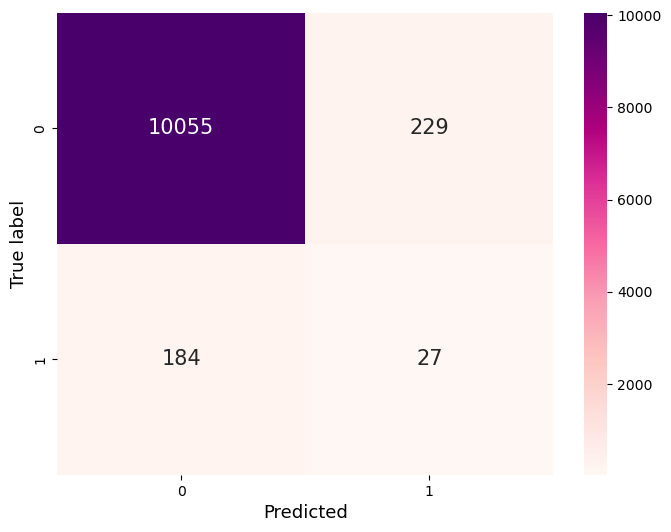

In [74]:
roc_auc_rf = round(roc_auc_score(y_test, y_test_proba_rf[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_rf:.4f}')

y_predict_rf = randomized_search.predict(X_test)
f1_rf = round(f1_score(y_test, y_predict_rf), 4)
print(classification_report(y_test, y_predict_rf))

cm_rf = confusion_matrix(y_test, y_predict_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

* TP = 27: в 27 случаях модель правильно отнесла значение к категории '1' (клиент совершил покупку в целевом периоде);
* FP = 229: в 229 случаях модель неправильно отнесла к категории '1' (ошибка 1-го рода) (клиент на самом деле не совершил покупку);
* FN = 184: в 184 случаях модель неправильно отнесла совершение покупки к категории '0' (ошибка 2-го рода);
* TN = 10055: в 10055 случаях модель правильно отнесла несовершение покупки к категории '0'.

Модель плохо предсказывает класс 1, в отличие от класса 0. 

Попробуем применить RandomUnderSampler для обработки наших несбалансированных данных, чтобы убрать дисбаланс целевого признака.

In [75]:
# Создание пайплайна с RandomUnderSampler для устранения дисбаланса
pipe_imb = ImbPipeline([
('preprocessor', data_preprocessor),
('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),
('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [84]:
param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10)
    },

        
    # словарь для модели RandomForestClassifier() 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(150, 300),
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 3),
        'models__class_weight': ['balanced', 'balanced_subsample']
    },
     
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='poly')],
        'models__C': [0.001, 0.01, 0.1, 1, 10],
        'models__gamma': ['scale', 'auto']        
    },

    # CatBoostClassifier()
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__iterations': [500, 2000],
        'models__depth': [10, 12],
        'models__auto_class_weights': ['Balanced', 'SqrtBalanced'],
        'models__learning_rate': [0.1, 0.3, 0.5, 0.68, 0.7, 0.8]        
    },

    # словарь для модели LightGBMClassifier()
    {
        'models__n_estimators': [100, 700],
        'models__num_leaves': [31, 63],
        'models__learning_rate': [0.05, 0.1],
        'models__min_child_samples': [20, 50]        
    }
]


In [85]:
randomized_search_imb = RandomizedSearchCV(
    pipe_imb, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=1
)

In [86]:
randomized_search_imb.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 10), 'models__min_samples_split': range(2, 10)}, {'models': [RandomForestC...ndom_state=42)], 'models__class_weight': ['balanced', 'balanced_subsample'], 'models__max_depth': [10, 15, ...], 'models__min_samples_leaf': range(1, 3), ...}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [87]:
print('Лучшая модель и её параметры:\n\n', randomized_search_imb.best_estimator_)
print('Лучшие значения параметров: {}'.format(randomized_search_imb.best_params_))
print('Лучшая метрика на кросс-валидации:', round(randomized_search_imb.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', CatBoostEncoder(),
                                                  ['main_category']),
                                                 ('num', StandardScaler(),
                                                  ['total_purchase_value',
                                                   'days_since_last_purch',
                                                   'purchase_period',
                                                   'quantity', 'cat_count',
                                                   'email', 'mobile_push',
                                                   'open', 'click', 'purchase',
                                                   'subscribe'])])),
                ('sampling', RandomUnderSampler(random_state=42)),
                ('models',
                 RandomForestClassifier

In [90]:
print(f'Точность на тесте: {randomized_search_imb.score(X_test, y_test):.4f}')

Точность на тесте: 0.7346


In [91]:
y_test_pred_imb = randomized_search_imb.predict(X_test)
y_test_proba_imb = randomized_search_imb.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba_imb[:,1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.7346


Метрика ROC-AUC на тестовой выборке: 0.7346
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     10284
           1       0.04      0.69      0.08       211

    accuracy                           0.67     10495
   macro avg       0.52      0.68      0.44     10495
weighted avg       0.97      0.67      0.79     10495



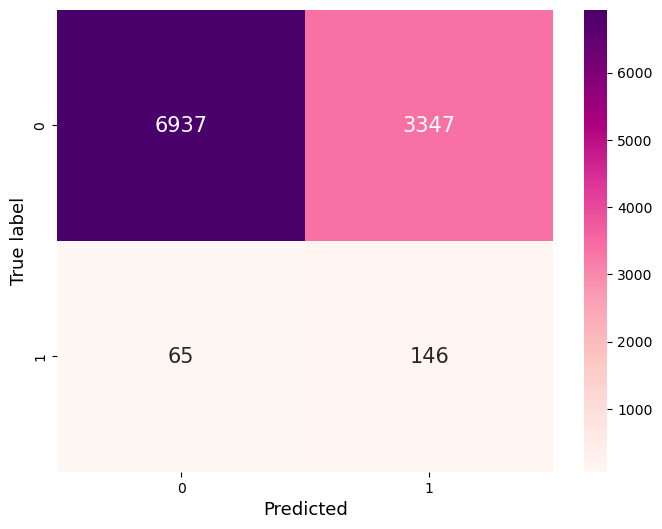

In [92]:
roc_auc_imb = round(roc_auc_score(y_test, y_test_proba_imb[:,1]), 4) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_imb:.4f}')

y_predict_imb = randomized_search_imb.predict(X_test)
f1_imb = round(f1_score(y_test, y_predict_imb), 4)
print(classification_report(y_test, y_predict_imb))

cm_imb = confusion_matrix(y_test, y_predict_imb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_imb, annot=True, fmt='d', cmap='RdPu', annot_kws={'size': 15})
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted', fontsize=13)
plt.show()

Матрица ошибок 

* TP = 146: в 146 случаях модель правильно отнесла значение к категории '1' (клиент совершил покупку в целевом периоде);
* FP = 3347: в 3347 случаях модель неправильно отнесла к категории '1' (ошибка 1-го рода) (клиент на самом деле не совершил покупку);
* FN = 65: в 65 случаях модель неправильно отнесла совершение покупки к категории '0' (ошибка 2-го рода);
* TN = 6937: в 6937 случае модель правильно отнесла отсутствие риска сердечного приступа к категории '0'.

Выросло ТР, также увеличилось и количество ошибок 1-го рода. В то же время снизились FN и TN.  
Стал лучше предсказываться 1 класс.

Метрика ROC-AUC улучшилась.

In [93]:
f1_imb

0.0788

***Лучшей моделью будем считать:***

- {'models__n_estimators': 230, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)} 
с применением RandomUnderSampler

Ее преимущества:

- обнаруживает на 119 больше реальных случаев совершения покупки в ближайшее время (146 vs 27)
- меньше ошибок 2-го рода (65 vs 184), т.е. совершение покупки в целевом периоде относится, наоборот, к "несовершению".

Лучше метрика ROC-AUC (0.7404 на тренировочной выборке и 0.7346 на тестовой выборке vs 0.702 на тренировочной выборке и 0.7232 на тестовой выборке).

**Анализ значимости признаков**

In [99]:
model = randomized_search_imb.best_estimator_.named_steps['models']
feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Значимость': feature_importance
}).sort_values('Значимость', ascending=False)

print("Значимость признаков:")
print(importance_df)

Значимость признаков:
                  Признак  Значимость
2         purchase_period    0.210747
9                   click    0.116491
7             mobile_push    0.108123
8                    open    0.105150
1   days_since_last_purch    0.100749
0    total_purchase_value    0.091835
6                   email    0.080176
4               cat_count    0.077103
3                quantity    0.061006
10               purchase    0.036945
5           main_category    0.011674
11              subscribe    0.000000


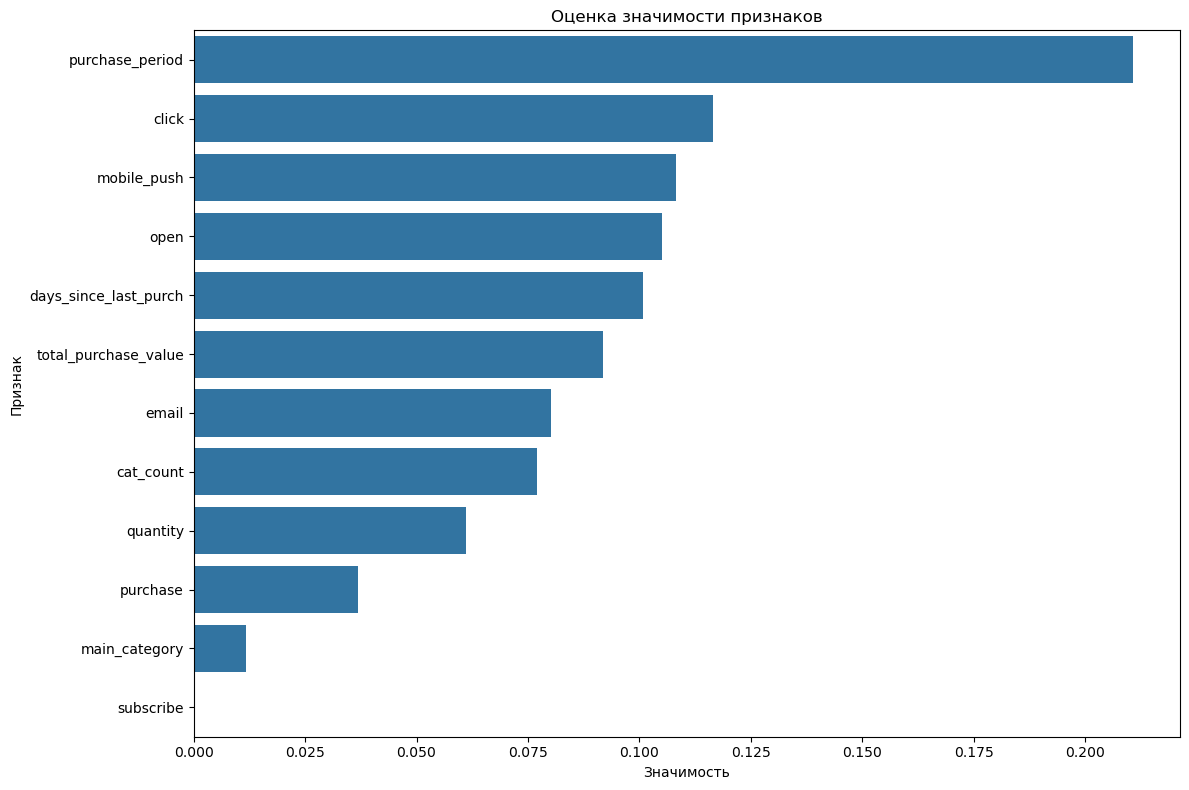

In [100]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Значимость', y='Признак', data=importance_df)
plt.title('Оценка значимости признаков')
plt.tight_layout()
plt.show()

Самыми значимыми признаками для данной модели являются:  

- `purchase_period` (период, в течение которого клиент совершал покупки)
- `click` (количество сделанных "кликов")
- `mobile_push`(количество полученных push-уведомлений)
- `open` (количество открытых сообщений)
- `days_since_last_purch` (количество дней с момента последней покупки)


Были выбраны, подготовлены и с помощью RandomizedSearch обучены различные модели c разными гиперпараметрами.

Чтобы улучшить модели мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке).

В итоге, в качестве лучшей модели была выбрана:  

{'models__n_estimators': 230, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}

**Общий вывод**  

Основной задачей проекта было разработать модель машинного обучения для предсказания вероятности совершения покупки в ближайшее время, используя данные о покупках клиентов, рассылках, которые были отправлены клиентам.

Для реализации задачи была проведена предварительная подготовка имеющихся наборов данных (поиск пропусков, явных и неявных дубликатов и т.д.), проведен исследовательский и корреляционный анализ данных.
Были удалены некоторые признаки и создадны новые. 

В ходе исследования были разработаны и обучены модели: DecisionTreeClassifier(), SVC(), LightGBMClassifier(), CatBoostClassifier() и RandomForestClassifier() c разными гиперпараметрами, а также проведен анализ важности признаков.

На первом этапе остановились на модели RandomForestClassifier(). Затем чтобы улучшить модель мы использовали RandomUnderSampler (для устранения дисбаланса в целевом признаке).

В итоге, в качестве лучшей модели была выбрана:

{'models__n_estimators': 230, 'models__min_samples_split': 3, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__class_weight': 'balanced_subsample', 'models': RandomForestClassifier(random_state=42)}

которая показала метрику ROC-AUC 0.7404 на тренировочной выборке. 

Наиболее важными с точки зрения модели признаками оказались следующие (в порядке уменьшения важности): 
- `purchase_period` (период, в течение которого клиент совершал покупки)
- `click` (количество сделанных "кликов")
- `mobile_push`(количество полученных push-уведомлений)
- `open` (количество открытых сообщений)
- `days_since_last_purch` (количество дней с момента последней покупки).

Таким образом, важно обратить внимание на следующие показатели:

- длительность периода, в течение которого клиент совершал покупки
- сколько раз клиент кликнул на push-уведомление
- сколько push-уведомлений было открыто клиентом
- количество покупок по email-рассылке
- сколько раз клиент отписался от email-рассылки
- сумма покупок клиента
- когда была совершена последняя покупка
